In [1]:
import requests
import json
from os import path
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### API CONFIGUATION

In [2]:
BASE_URL = "https://rest.coinapi.io/"

API_KEY = "AE6EB1CB-8CD4-400E-80A6-A3A8792CB183"

### API SERVICE

In [2]:
class APIService:
    def __init__(self, assets, ticker_period):
        self.assets = assets
        self.ticker_period = ticker_period
        self.headers = {
            'Accept': 'text/plain',
            'X-CoinAPI-Key': API_KEY
        }
        self.base_url = BASE_URL
        self.payload = {}
     
    # The objective is to combine intervals of days following a quota of 100 days according to start_date and end_date (since the API collects on 100 days/request).
    # date_start / date_end: date objects
    # max_days : int
    # start : 1/5/2024
    # End : 19/9/2024
    # -> [[1/5/2024, 10/08/2024], [11/08/2024, 19/09/2024]] 
    
    def get_dates_intervals(self, start_date, end_date, max_days):
        diff = end_date - start_date
        diff_days = abs(diff.days)
        dates_intervals = []
        interval_begin_date = start_date

        while diff_days > 0:
            nb_days_to_add = max_days - 1
            if diff_days < max_days - 1:
                nb_days_to_add = diff_days
            interval_end_date = interval_begin_date + timedelta(nb_days_to_add)
            dates_intervals.append([interval_begin_date, interval_end_date])
            diff_days -= nb_days_to_add + 1
            interval_begin_date = interval_end_date + timedelta(1)

        return dates_intervals

    # Call the API and display the result as it is.
    
    def get_exchange_rates(self, start_date, end_date):
        start_date_str = start_date.strftime("%Y-%m-%d")
        end_date_str = (end_date + timedelta(1)).strftime("%Y-%m-%d")

        url = f"{self.base_url}v1/exchangerate/{self.assets}/history?period_id={self.ticker_period}&time_start={start_date_str}T00:00:00&time_end={end_date_str}T00:00:00"

        response = requests.request("GET", url, headers=self.headers, data=self.payload)

        if response.status_code == 200:
            return json.loads(response.text)
        else:
            print(f"API Error: {response.status_code}")
            return None

    # extended : start and end dates can be separeted more than 100 days
    
    def get_exchange_rates_extended(self, start_date, end_date):
        rates = []
        date_intervals = self.get_dates_intervals(start_date, end_date, 100)
        for interval in date_intervals:
            interval_rates = self.get_exchange_rates(interval[0], interval[1])
            if interval_rates:
                rates += interval_rates
        return rates

    def get_filtered_rates(self, start_date, end_date):
        rates = self.get_exchange_rates_extended(start_date, end_date)
        return self.filter_inconsistent_rate_values(rates)

    # I want to reduce error ranges on highs, lows and closes

    def filter_inconsistent_rate_values(self, input_rates):
        def rate_is_inconsistent(rate):
            v = rate["rate_open"]
            vmin = v / 10
            vmax = v * 10
            if not vmin <= rate["rate_close"] <= vmax:
                return True
            if not vmin <= rate["rate_high"] <= vmax:
                return True
            if not vmin <= rate["rate_low"] <= vmax:
                return True
            return False

        filtered_rates = []
        for i, r in enumerate(input_rates):
            if rate_is_inconsistent(r):
                # take the day before and the day after
                reference_rate = input_rates[i - 1] if i > 0 else input_rates[i + 1]
                r["rate_open"] = reference_rate["rate_open"]
                r["rate_close"] = reference_rate["rate_close"]
                r["rate_high"] = reference_rate["rate_high"]
                r["rate_low"] = reference_rate["rate_low"]
            filtered_rates.append(r)
        return filtered_rates

### RATES DATA MANAGER

In [1]:
class RatesDataManager:
    def __init__(self, api_service):
        self.api_service = api_service

    def load_json_data_from_file(self, filename):
        """Load rates data from the JSON file."""
        with open(filename, "r") as f:
            return json.load(f)

    def save_rates_data_to_file(self, filename, rates_data):
        """Save the rates data to a JSON file."""
        with open(filename, "w") as f:
            json.dump(rates_data, f)

    def convert_rates_to_date_value_format(self, rates_data):
        """Convert rates data to the desired date-value format."""

        return [{"Date": r["time_period_start"][:10], "Close": r["rate_close"]} for r in rates_data]

    def get_and_manage_rates_data(self, assets, start_date, end_date, ticker_period):
        """Helper to generate the file name for saving JSON data."""
        data_filename = assets.replace("/", "_") + ".json"
        rates = []

        if path.exists(data_filename):
            rates = self.load_json_data_from_file(data_filename)
            if rates:
                print("The json file exists")
                # Convert str date to date objet
                saved_data_date_start = datetime.strptime(rates[0]["Date"], "%Y-%m-%d").date()
                saved_data_date_end = datetime.strptime(rates[-1]["Date"], "%Y-%m-%d").date()

                # Is the new end_date greater than the one already saved (saved_data_date_end)?
                if start_date < saved_data_date_start:
                    print(f"Fetching data from {start_date} to {saved_data_date_start - timedelta(1)}")
                    # - so we make calls to the api (before) ←-- pass the 100-day limit
                    rates_start = self.api_service.get_filtered_rates(start_date, saved_data_date_start - timedelta(1))
                    # saved_data_date_start - timedelta(1) because we don't want to include an existing date
                    rates = self.convert_rates_to_date_value_format(rates_start) + rates

                # Is the new end_date greater than the one already saved (saved_data_date_end)?
                if end_date > saved_data_date_end:
                    print(f"Fetching data from {saved_data_date_end + timedelta(1)} to {end_date}")
                    rates_end = self.api_service.get_filtered_rates(saved_data_date_end + timedelta(1), end_date)
                    # saved_data_date_end + timedelta(1) because we don't want to include an existing date
                    rates += self.convert_rates_to_date_value_format(rates_end)

                # Consolidate data (update json file)
                self.save_rates_data_to_file(data_filename, rates)
            else:
                rates = self._fetch_and_save_rates(data_filename, assets, start_date, end_date)
        else:
            rates = self._fetch_and_save_rates(data_filename, assets, start_date, end_date)

        return rates

    def _fetch_and_save_rates(self, filename, assets, start_date, end_date):
        rates = self.api_service.get_filtered_rates(start_date, end_date)
        rates = self.convert_rates_to_date_value_format(rates)
        self.save_rates_data_to_file(filename, rates)
        return rates

### MAIN

In [5]:
ticker = "EUR/USD"
ticker_period = "1DAY"
start_date = date(2024, 8, 21)
end_date = date.today() - timedelta(1)

# Initialize API service and data manager
api_service = APIService(ticker, ticker_period)
data_manager = RatesDataManager(api_service)

# Fetch and manage rates data
rates = data_manager.get_and_manage_rates_data(ticker, start_date, end_date, ticker_period)
print(rates)
print("Total rates fetched:", len(rates))
rates_dates = [datetime.strptime(r["Date"], "%Y-%m-%d") for r in rates]
rates_values = [r["Close"] for r in rates]

[{'Date': '2014-10-21', 'Close': 1.270781505334}, {'Date': '2014-10-22', 'Close': 1.26202332290876}, {'Date': '2014-10-23', 'Close': 1.26029560532322}, {'Date': '2014-10-24', 'Close': 1.26130667360218}, {'Date': '2014-10-25', 'Close': 1.25643071772364}, {'Date': '2014-10-26', 'Close': 1.25668909977459}, {'Date': '2014-10-27', 'Close': 1.25277714281734}, {'Date': '2014-10-28', 'Close': 1.26081701209287}, {'Date': '2014-10-29', 'Close': 1.25556149810931}, {'Date': '2014-10-30', 'Close': 1.26897549366496}, {'Date': '2014-10-31', 'Close': 1.24918758288457}, {'Date': '2014-11-01', 'Close': 1.25169748498089}, {'Date': '2014-11-02', 'Close': 1.25125322326596}, {'Date': '2014-11-03', 'Close': 1.24736442430475}, {'Date': '2014-11-04', 'Close': 1.2619090096757}, {'Date': '2014-11-05', 'Close': 1.25293115440107}, {'Date': '2014-11-06', 'Close': 1.25513409047169}, {'Date': '2014-11-07', 'Close': 1.25007650688676}, {'Date': '2014-11-08', 'Close': 1.25469935628802}, {'Date': '2014-11-09', 'Close': 1

In [6]:
df = pd.DataFrame(rates)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# 2. Data Exploration & Visualization

In [7]:
df.head()

,Close
Date,
2014-10-21,1.270782
2014-10-22,1.262023
2014-10-23,1.260296
2014-10-24,1.261307
2014-10-25,1.256431


In [8]:
df.tail()

,Close
Date,
2024-10-16,1.086156
2024-10-17,1.083854
2024-10-18,1.086649
2024-10-19,1.087877
2024-10-20,1.087943


In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
df.shape

(3653, 1)

In [11]:
df.isna().sum()

Close    0
dtype: int64

In [12]:
df.describe()

,Close
count,3653.000000
mean,1.121819
std,0.054311
min,0.959523
25%,1.085649
50%,1.116168
75%,1.160956
max,1.306332


In [13]:
df.dtypes

Close    float64
dtype: object

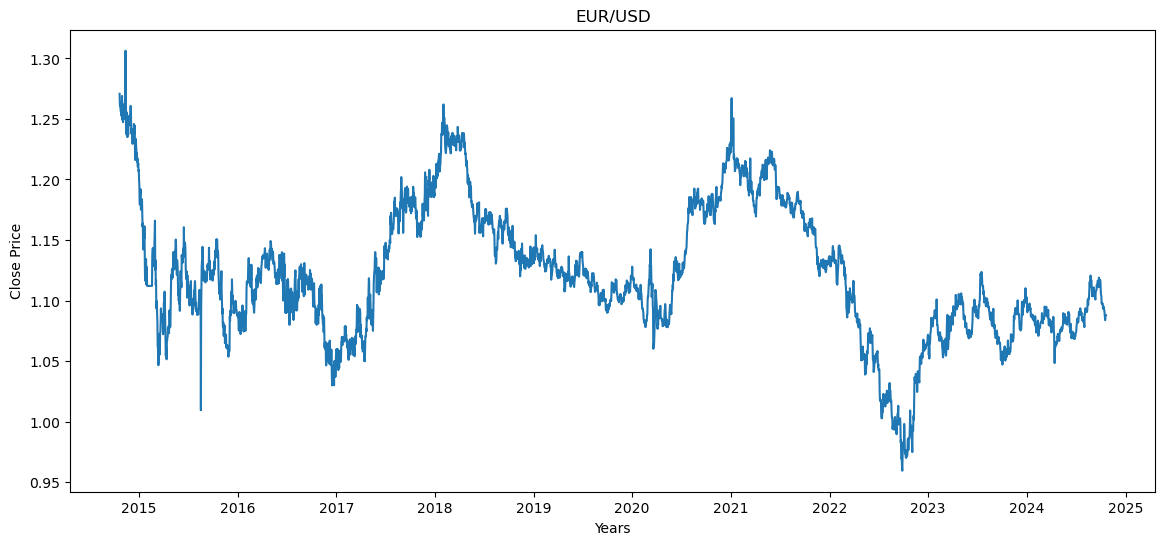

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df.Close)  # <-- valeurs
plt.title(ticker);
plt.xlabel('Years');
plt.ylabel('Close Price');

# 3. Feature Engineering

In [15]:
df1 = pd.DataFrame([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
df1

,0
0,10
1,20
2,30
3,40
4,50
5,60
6,70
7,80
8,90
9,100


In [16]:
df1['MA_5'] = df1.rolling(5).mean()
df1

,0,MA_5
0,10,NaN
1,20,NaN
2,30,NaN
3,40,NaN
4,50,30.0
5,60,40.0
6,70,50.0
7,80,60.0
8,90,70.0
9,100,80.0


## 100 days Moving Average

In [17]:
df['MA_100'] = df.Close.rolling(100).mean()
df.head(103)

,Close,MA_100
Date,,
2014-10-21,1.270782,NaN
2014-10-22,1.262023,NaN
2014-10-23,1.260296,NaN
2014-10-24,1.261307,NaN
2014-10-25,1.256431,NaN
...,...,...
2015-01-27,1.134363,NaN
2015-01-28,1.113276,1.220647
2015-01-29,1.127860,1.219218


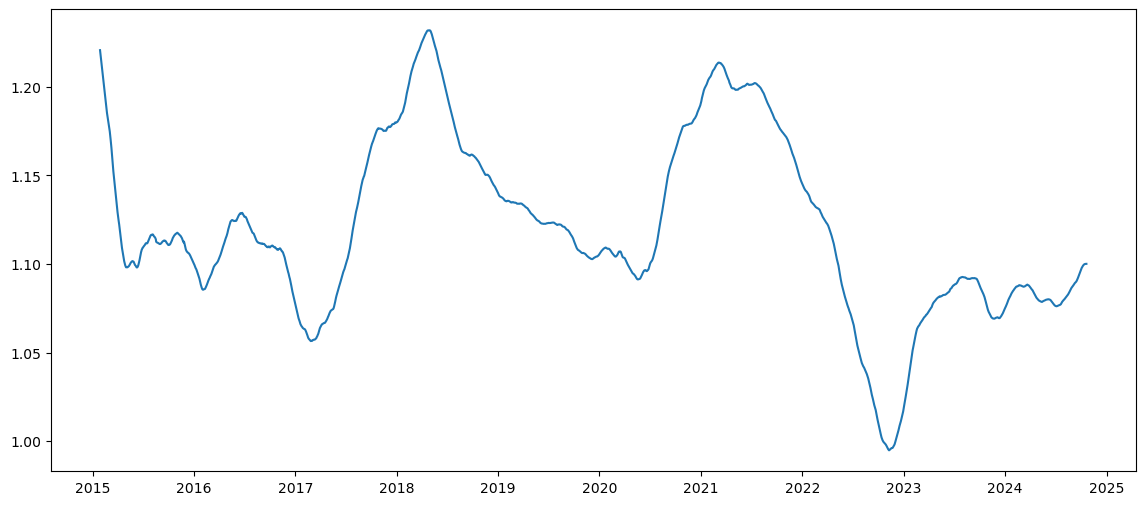

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(df['MA_100'])

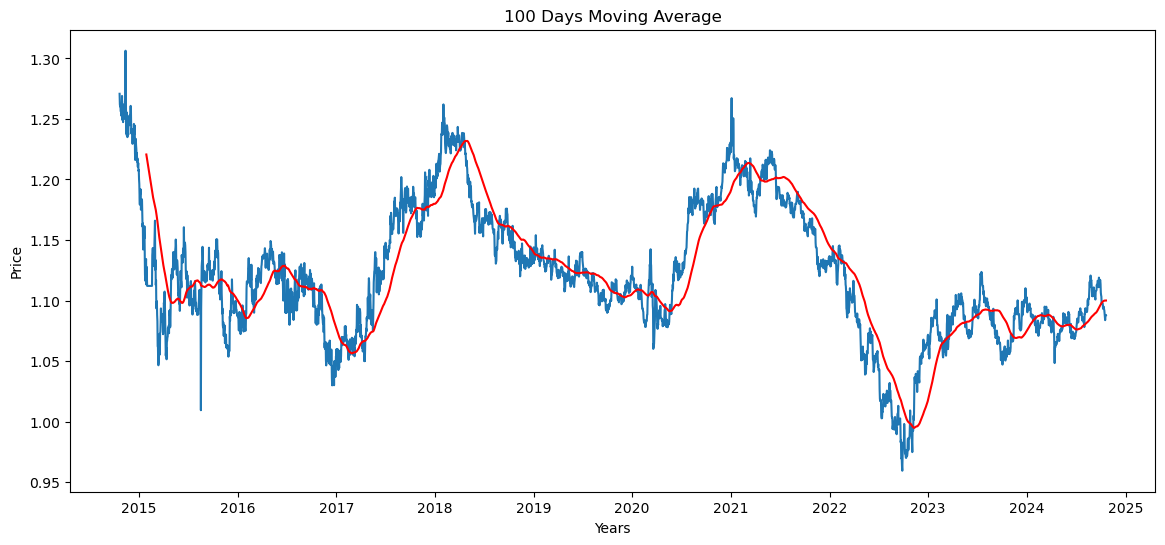

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(df.Close);
plt.plot(df['MA_100'], 'r')
plt.title('100 Days Moving Average');
plt.xlabel('Years');
plt.ylabel('Price');

## 200 days Moving Average

In [20]:
df['MA_200'] = df.Close.rolling(200).mean()
df.head(203)

,Close,MA_100,MA_200
Date,,,
2014-10-21,1.270782,NaN,NaN
2014-10-22,1.262023,NaN,NaN
2014-10-23,1.260296,NaN,NaN
2014-10-24,1.261307,NaN,NaN
2014-10-25,1.256431,NaN,NaN
...,...,...,...
2015-05-07,1.130354,1.098113,NaN
2015-05-08,1.140129,1.098381,1.159514
2015-05-09,1.133761,1.098440,1.158829


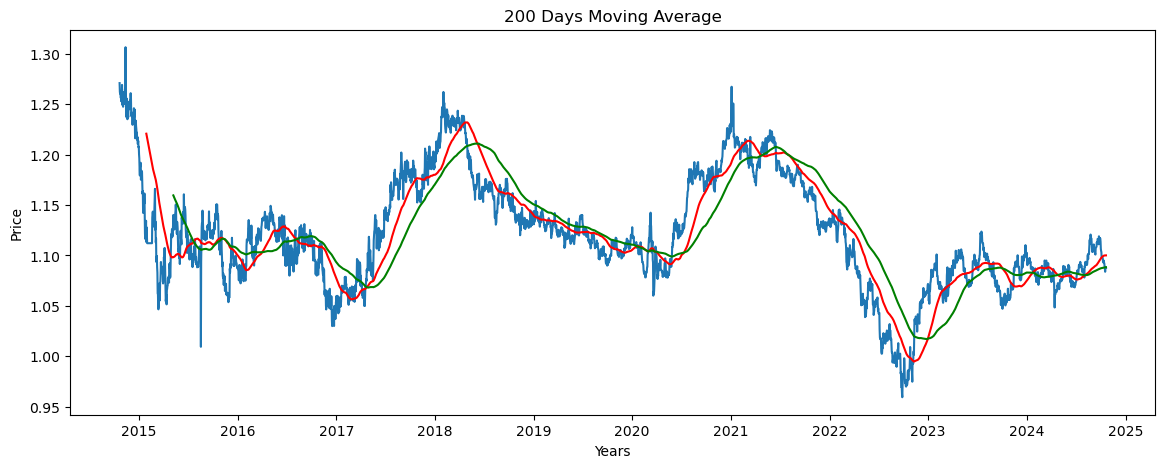

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(df.Close);
plt.plot(df['MA_100'], 'r')
plt.plot(df['MA_200'], 'g')
plt.title('200 Days Moving Average');
plt.xlabel('Years');
plt.ylabel('Price');

### Calculating % changed in each trading session

In [22]:
df['Percentage Changed'] = df.Close.pct_change()
df[['Close', 'Percentage Changed']]

,Close,Percentage Changed
Date,,
2014-10-21,1.270782,NaN
2014-10-22,1.262023,-0.006892
2014-10-23,1.260296,-0.001369
2014-10-24,1.261307,0.000802
2014-10-25,1.256431,-0.003866
...,...,...
2024-10-16,1.086156,-0.003037
2024-10-17,1.083854,-0.002119
2024-10-18,1.086649,0.002579


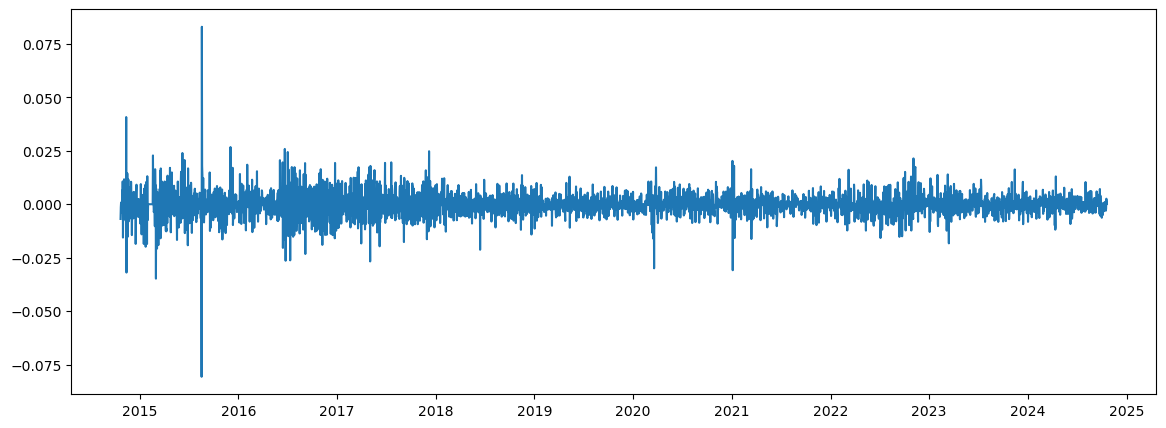

In [23]:
plt.figure(figsize=(14, 5))
plt.plot(df['Percentage Changed']);

# 4. Data Processing

In [71]:
df = df.reset_index()

In [72]:
df.shape

(3653, 6)

In [26]:
len(df)

3653

In [27]:
# Splitting data into Training and Testing datasets
data_training = pd.DataFrame(df.Close[0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df.Close[int(len(df)*0.7): int(len(df))])

In [69]:
data_training

,Close
0,1.270782
1,1.262023
2,1.260296
3,1.261307
4,1.256431
...,...
2552,1.164295
2553,1.160956
2554,1.161003
2555,1.164480


In [29]:
data_testing

,Close
2557,1.163520
2558,1.164200
2559,1.162179
2560,1.163486
2561,1.161178
...,...
3648,1.086156
3649,1.083854
3650,1.086649
3651,1.087877


In [30]:
type(data_testing)

pandas.core.frame.DataFrame

# Scaling down the data between 0 & 1

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [32]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.88023588],
       [0.85073104],
       [0.84491066],
       ...,
       [0.51040938],
       [0.52212529],
       [0.53229674]])

In [33]:
type(data_training_array)

numpy.ndarray

In [34]:
data_training_array.shape

(2557, 1)

# 5. Sequence Creation

In [35]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [36]:
x_train

array([[[0.88023588],
        [0.85073104],
        [0.84491066],
        ...,
        [0.39883346],
        [0.4206654 ],
        [0.34962794]],

       [[0.85073104],
        [0.84491066],
        [0.84831677],
        ...,
        [0.4206654 ],
        [0.34962794],
        [0.39875886]],

       [[0.84491066],
        [0.84831677],
        [0.8318905 ],
        ...,
        [0.34962794],
        [0.39875886],
        [0.37366578]],

       ...,

       [[0.59631714],
        [0.59790862],
        [0.59309635],
        ...,
        [0.51248678],
        [0.52150121],
        [0.51025334]],

       [[0.59790862],
        [0.59309635],
        [0.56880098],
        ...,
        [0.52150121],
        [0.51025334],
        [0.51040938]],

       [[0.59309635],
        [0.56880098],
        [0.58582148],
        ...,
        [0.51025334],
        [0.51040938],
        [0.52212529]]])

In [37]:
y_train

array([0.39875886, 0.37366578, 0.34576501, ..., 0.51040938, 0.52212529,
       0.53229674])

In [38]:
x_train.ndim

3

In [39]:
y_train.ndim

1

In [40]:
x_train.shape


(2457, 100, 1)

In [41]:
y_train.shape

(2457,)

# 6. Model Building

In [42]:
import tensorflow as tf
# Ml Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

In [43]:
model = Sequential()

model.add(Input(shape=(100, 1))) # Input layer
model.add(LSTM(units=128, activation='tanh', return_sequences=True)) # 128 neurons, the LSTM layer will produce an output for each of these layers
model.add(LSTM(units=64)) # This layer takes the output sequence generated by the first layer and produces a single output
model.add(Dense(25)) # 25 unique results will be produced
model.add(Dense(1)) # it combines them into a single output. It gives the final price forecast.

# 7. Model Training

In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)  # epochs=50 === Read data 50 times

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 27s 146ms/step - loss: 0.0215
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0014
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0014
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - loss: 0.0012
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - loss: 0.0014
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - loss: 0.0012
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - loss: 0.0011
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: 8.5955e-04
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 8.7297e-04
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - loss: 8.4307e-04
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - loss: 8.2274e-04
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - loss: 9.1653e-04
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 8.4795e-04
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 150ms/step - loss: 7.2201e-04
Epoch 15/50
77/

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [46]:
# save the trained model
model.save('stock_prediction_algo_lstm_model.keras')

# 8. Preparing Test Data

In [50]:
data_training.tail(100) # We want to predict the last 100 days of data_training

,Close
2457,1.178336
2458,1.183388
2459,1.181640
2460,1.180568
2461,1.180372
...,...
2552,1.164295
2553,1.160956
2554,1.161003
2555,1.164480


In [47]:
data_testing

,Close
2557,1.163520
2558,1.164200
2559,1.162179
2560,1.163486
2561,1.161178
...,...
3648,1.086156
3649,1.083854
3650,1.086649
3651,1.087877


In [51]:
past_100_days = data_training.tail(100)

In [52]:
past_100_days

,Close
2457,1.178336
2458,1.183388
2459,1.181640
2460,1.180568
2461,1.180372
...,...
2552,1.164295
2553,1.160956
2554,1.161003
2555,1.164480


In [53]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
final_df

,Close
0,1.178336
1,1.183388
2,1.181640
3,1.180568
4,1.180372
...,...
1191,1.086156
1192,1.083854
1193,1.086649
1194,1.087877


In [54]:
# Convert data between 0 & 1
input_data = scaler.fit_transform(final_df)
input_data

array([[0.94999297],
       [0.97192819],
       [0.96434069],
       ...,
       [0.55192899],
       [0.55725949],
       [0.55754498]])

In [55]:
input_data.shape

(1196, 1)

In [56]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [57]:
x_test

array([[[0.94999297],
        [0.97192819],
        [0.96434069],
        ...,
        [0.87474064],
        [0.88983954],
        [0.90294802]],

       [[0.97192819],
        [0.96434069],
        [0.95968414],
        ...,
        [0.88983954],
        [0.90294802],
        [0.88566901]],

       [[0.96434069],
        [0.95968414],
        [0.95883241],
        ...,
        [0.90294802],
        [0.88566901],
        [0.88862205]],

       ...,

       [[0.53630581],
        [0.55223662],
        [0.56900911],
        ...,
        [0.56415153],
        [0.54978591],
        [0.5397932 ]],

       [[0.55223662],
        [0.56900911],
        [0.57078162],
        ...,
        [0.54978591],
        [0.5397932 ],
        [0.55192899]],

       [[0.56900911],
        [0.57078162],
        [0.55942503],
        ...,
        [0.5397932 ],
        [0.55192899],
        [0.55725949]]])

In [58]:
x_test[0].shape

(100, 1)

# 9. Making Predictions

In [59]:
y_predicted = model.predict(x_test)  # We are now submitting the 100 data items extracted from x_test to the model for prediction.

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step


In [60]:
y_predicted

array([[0.9189024 ],
       [0.90036136],
       [0.905399  ],
       ...,
       [0.5538428 ],
       [0.56295717],
       [0.568694  ]], dtype=float32)

In [61]:
y_test

array([0.88566901, 0.88862205, 0.87984788, ..., 0.55192899, 0.55725949,
       0.55754498])

In [62]:
y_predicted = scaler.inverse_transform(y_predicted.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [63]:
y_predicted

array([1.1711744, 1.1669039, 1.1680642, ..., 1.0870901, 1.0891894,
       1.0905107], dtype=float32)

In [64]:
y_test

array([1.16351976, 1.16419993, 1.16217897, ..., 1.08664931, 1.08787708,
       1.08794284])

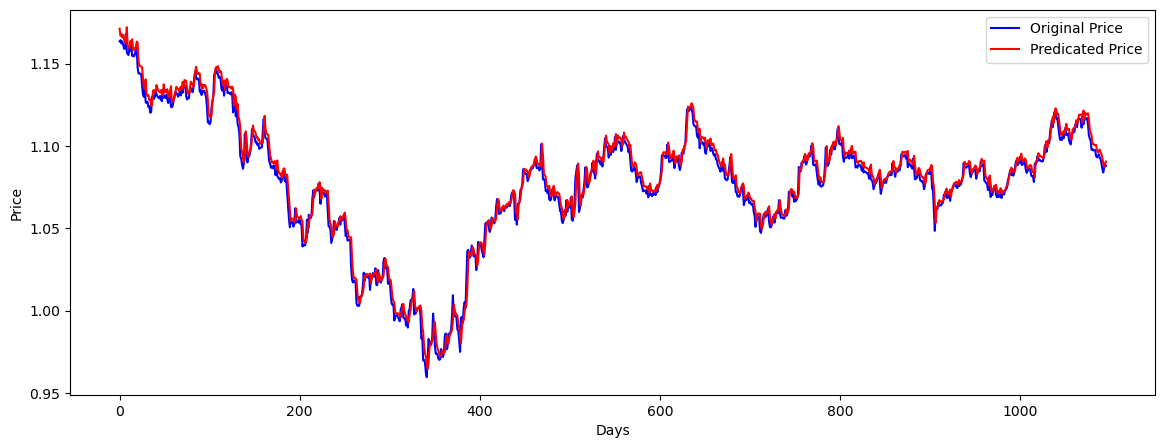

In [70]:
plt.figure(figsize=(14, 5))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicated Price')
plt.xlabel('Days');
plt.ylabel('Price');
plt.legend()

# 10. Model Evaluation

In [73]:
# Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error, r2_score

In [74]:
mse = mean_squared_error(y_test, y_predicted)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 2.7724527683919124e-05


In [76]:
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse} # of losses or by currency")

Root Mean Squared Error (RMSE): 0.005265408596103357 # of losses or by currency


In [77]:
# R-Squared 
r2 = r2_score(y_test, y_predicted)
print(f"R-Squared: {r2}")

R-Squared: 0.9807242483085326
